In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataframes
spend_revenue = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/spend_revenue.csv")
sales_full_merged = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/sales_full_merged.csv")
rfm = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/models/rfm.csv")
customer_features = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/models/customer_features.csv")

In [3]:
''' Define the cohort by first purchase month and calculate the cohort indices
'''


# convert Transaction_Date to datetime if not already done
sales_full_merged['Transaction_Date'] = pd.to_datetime(sales_full_merged['Transaction_Date'])

# create a cohort column that marks the month a customer made their first purchase
sales_full_merged['CohortMonth'] = sales_full_merged.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M')

# create a transaction month column for each transaction
sales_full_merged['TransactionMonth'] = sales_full_merged['Transaction_Date'].dt.to_period('M')

# verify
sales_full_merged[['CustomerID', 'Transaction_Date', 'CohortMonth', 'TransactionMonth']].head()

,CustomerID,Transaction_Date,CohortMonth,TransactionMonth
0,17850,2019-01-01,2019-01,2019-01
1,17850,2019-01-01,2019-01,2019-01
2,17850,2019-01-01,2019-01,2019-01
3,17850,2019-01-01,2019-01,2019-01
4,17850,2019-01-01,2019-01,2019-01


In [4]:
# calculate the number of months between the transaction and the cohort start month
sales_full_merged['CohortIndex'] = (sales_full_merged['TransactionMonth'] - sales_full_merged['CohortMonth']).apply(lambda x: x.n)

# verify
sales_full_merged[['CustomerID', 'CohortMonth', 'TransactionMonth', 'CohortIndex']].head()

,CustomerID,CohortMonth,TransactionMonth,CohortIndex
0,17850,2019-01,2019-01,0
1,17850,2019-01,2019-01,0
2,17850,2019-01,2019-01,0
3,17850,2019-01,2019-01,0
4,17850,2019-01,2019-01,0


In [5]:
# count unique customers
cohort_data = sales_full_merged.groupby(['CohortMonth', 'CohortIndex']).agg({'CustomerID': 'nunique'}).reset_index()

# make pivot table
cohort_pivot = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# verify pivot table
cohort_pivot.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,,
2019-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN


In [6]:
# replace NaNs with 0 for retention calculation
cohort_pivot.fillna(0, inplace=True)

# verify
cohort_pivot.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,,
2019-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,0.0
2019-03,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,0.0,0.0
2019-04,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,0.0,0.0,0.0
2019-05,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,0.0,0.0,0.0,0.0


In [7]:
# calculate retention rate by dividing by the cohort size (CohortIndex = 0)

# number of customers in the first month (CohortIndex = 0)
cohort_size = cohort_pivot.iloc[:, 0]
retention_rate = cohort_pivot.divide(cohort_size, axis=0)

# verify
retention_rate.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,,
2019-01,1.0,0.060465,0.111628,0.158140,0.106977,0.204651,0.162791,0.218605,0.106977,0.130233,0.093023,0.15814
2019-02,1.0,0.072917,0.093750,0.166667,0.177083,0.229167,0.197917,0.156250,0.125000,0.114583,0.166667,0.00000
2019-03,1.0,0.101695,0.197740,0.141243,0.180791,0.186441,0.124294,0.124294,0.084746,0.107345,0.000000,0.00000
2019-04,1.0,0.085890,0.147239,0.147239,0.110429,0.092025,0.061350,0.098160,0.073620,0.000000,0.000000,0.00000
2019-05,1.0,0.107143,0.080357,0.116071,0.089286,0.116071,0.125000,0.071429,0.000000,0.000000,0.000000,0.00000


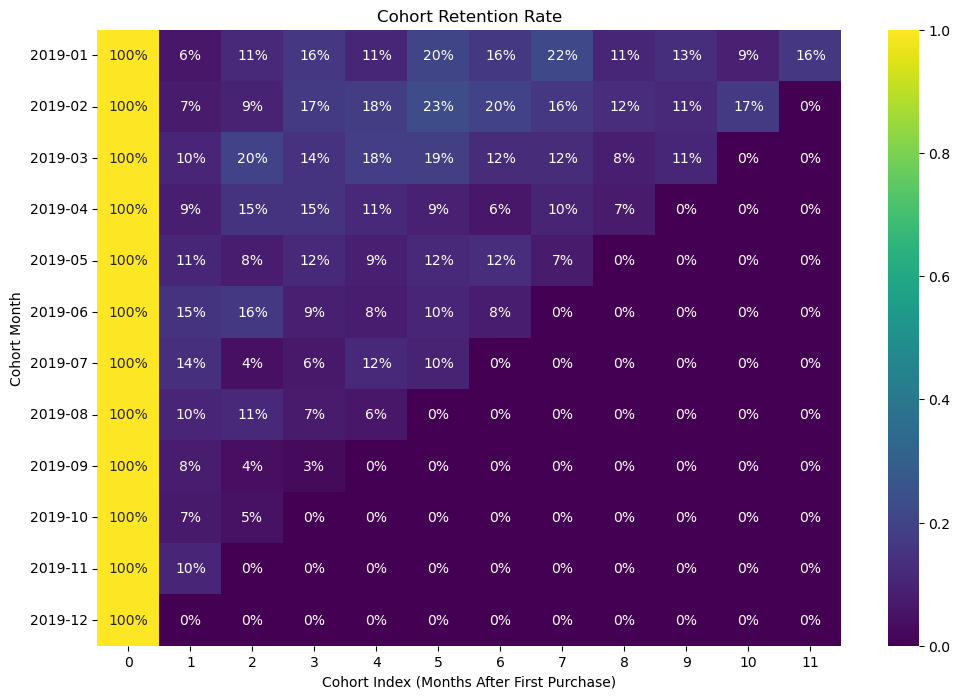

In [13]:
# visualize retention rates
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, fmt='.0%', cmap='viridis')
plt.title('Cohort Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index (Months After First Purchase)')
plt.show()